# Introduction
This project takes a tweet dataset and classifies the tweets to either 0 or 1, 0 being non-disaster related and 1 being disaster related. First, the dataset is briefly inspected, making note of the number of entries, data types, number of features, and missing values. It is then cleaned and preprocessed so that the tweets are removed of URLs, special characters and numbers, and tokenized. The training split is used to train the model, and the test split will be used to predict and record the accuracy.

##Exploratory Data Analysis (EDA)  
A brief inspection of the dataset will take place. General information such as number of observations, features, data types, and missing values will be the main concern in this process.

In [13]:
import keras
from numpy import asarray
from numpy import zeros
from sklearn.model_selection import train_test_split
import re
import csv
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
try:
  import ktrain
except:
  !pip install ktrain
  import ktrain
nltk.download('omw-1.4')
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [35]:
import ktrain
from ktrain import text
from ktrain.text import texts_from_df
from keras.preprocessing.text import Tokenizer

In [3]:
#Load data
path = 'drive/MyDrive/'
df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')
sol = pd.read_csv(path + 'sample_submission.csv')

In [4]:
#Examine overall data structure and contents
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [6]:
df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [7]:
sol.head(5)

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


The dataset has 7613 observations with no missing values.  
Upon observing the sample submission dataset, we can see the required format of our submission file. Now we will move on to text preprocessing. This part will remove any URLs, unnecessary characters, and tokenize the texts.

##Text Preprocessing
Implement helper functions to:
1. Lemmatize
2. Tokenize
3. Remove punctuation and stopwords

In [8]:
#Define functions for Lemmatize, remove stopwords, punctuation, and tokenize.
w_tok = nltk.tokenize.word_tokenize
STEM = nltk.PorterStemmer()
LEMM = nltk.WordNetLemmatizer()

def tokenize(text, lowercase=True):
    if lowercase:
        text = text.lower()
        return w_tok(text)

def stem(tokens):
    return [STEM.stem(token) for token in tokens]

def lemmatize(tokens):
    lemm = []
    for token in tokens:
        if isinstance(token, str):
            lemm.append(LEMM.lemmatize(token)) # treats token like a noun
        else: # assume a tuple of (word, pos)
            lemm.append(LEMM.lemmatize(*token))
    return lemm

def remove_stopwords(tokens, stopwords = None):
    if stopwords is None:
        stopwords = nltk.corpus.stopwords.words("english")
    return [token for token in tokens if token not in stopwords]

def remove_punctuation(tokens):
    return [token for token in tokens if token not in string.punctuation]

def remove_links(tokens):
    return [ t for t in tokens if not t.startswith("http://") and not t.startswith("https://")]

In [18]:
text_train = []
for i, t in enumerate(df['text']):
    texts = t
    prep_text = tokenize(texts)
    prep_text = remove_stopwords(prep_text)
    prep_text = remove_punctuation(prep_text)
    prep_text = lemmatize(prep_text)
    text_train.append(' '.join(prep_text))

In [19]:
df['Prep_Text'] = text_train
df['Word_Counts'] = df['Prep_Text'].apply(lambda lst: len(lst))
target = ['Non-Disaster', 'Disaster']
df['target'].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

We see that the target feature values are slightly unbalanced, with more values of 0 than 1. Let's balance this to avoid over/underfitting.

In [20]:
disaster = df[df['target'] == 1]
non_disaster = df[df['target'] == 0].sample(n = 3271)

Before progressing further, let's inspect the number of words per tweet.

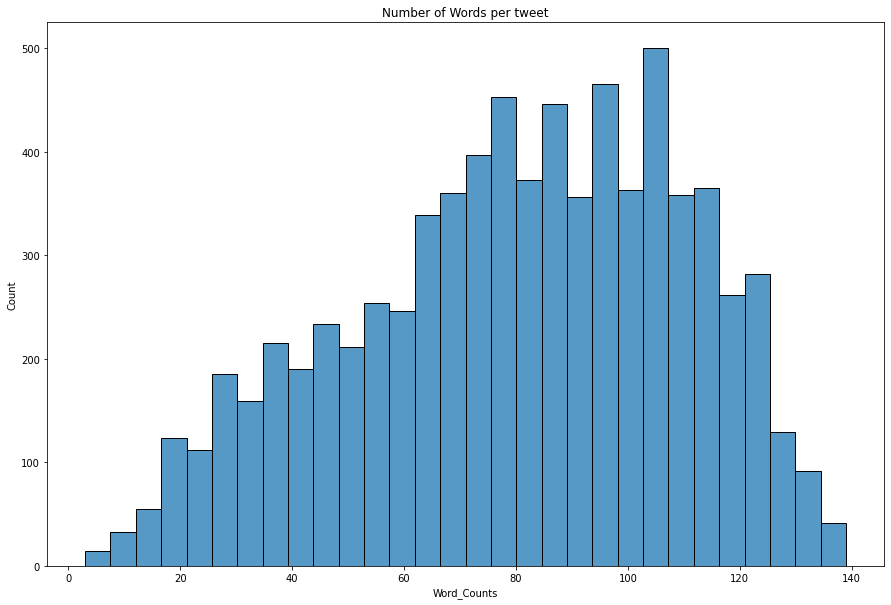

In [21]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.histplot(
    data = df,
    x = 'Word_Counts').set(title = 'Number of Words per tweet');

The word count per tweet distribution appears to be slightly negatively skewed, with the mode having 100-110 words.

In [25]:
total = pd.concat([disaster, non_disaster])

In [23]:
print(df.head(5))
print(total.describe())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                          Prep_Text  Word_Counts  
0       1         deed reason earthquake may allah forgive u           42  
1       1              forest fire near la ronge sask canada           37  
2       1  resident asked 'shelter place notified officer...           86  
3       1  13,000 people receive wildfire evacuation orde...           58  
4       1  got sent photo ruby alaska smoke wildfire pour...           54  
                 id       target  Word_Counts
count   6542.000000  6542.000000  6

The texts are nicely preprocessed, with a balanced distribution of disaster/non-disaster ratio. We can now train and generate the model.

In [36]:
t = text.Transformer('distilbert-base-uncased', maxlen = 512, class_names = target)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [37]:
train, val, preprocess = texts_from_df(total, 'Prep_Text', label_columns = ['target'], val_df = None, max_features=20000, maxlen=512, val_pct=0.1, ngram_range=1, preprocess_mode='distilbert', verbose=1)

['not_target', 'target']
      not_target  target
4301         1.0     0.0
3795         0.0     1.0
5884         0.0     1.0
169          0.0     1.0
3613         0.0     1.0
['not_target', 'target']
      not_target  target
2969         1.0     0.0
3608         1.0     0.0
4892         0.0     1.0
4162         1.0     0.0
2321         0.0     1.0
preprocessing train...
language: en
train sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 19


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 11
	95percentile : 17
	99percentile : 19


In [ ]:
model = preprocess.get_classifier()
learner = ktrain.get_learner(model, train_data = train, val_data = val, batch_size = 16)

In [ ]:
learner.lr_find(max_epochs = 6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
367/367 [==============================] - 343s 908ms/step - loss: 0.6885 - accuracy: 0.5363
Epoch 2/10
367/367 [==============================] - 332s 906ms/step - loss: 0.5697 - accuracy: 0.7384
Epoch 3/10
367/367 [==============================] - 332s 905ms/step - loss: 0.4211 - accuracy: 0.8152
Epoch 4/10
367/367 [==============================] - 332s 905ms/step - loss: 0.3977 - accuracy: 0.8285
Epoch 5/10
367/367 [==============================] - 332s 905ms/step - loss: 0.5519 - accuracy: 0.6941
Epoch 6/10
367/367 [==============================] - 330s 900ms/step - loss: 0.6944 - accuracy: 0.5014
Epoch 7/10
367/367 [==============================] - 327s 890ms/step - loss: 0.7050 - accuracy: 0.5001
Epoch 8/10
367/367 [==============================] - 326s 887ms/step - loss: 0.7022 - accuracy: 0.4923
Epoch 9/10
367/367 [==============================] - 326s 887ms/step - loss: 0.7249 

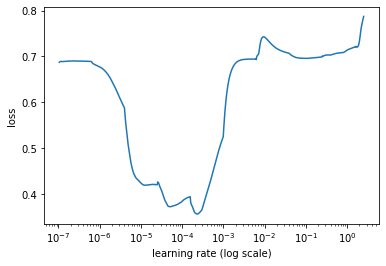

In [ ]:
learner.lr_plot()

In [ ]:
history=learner.autofit(1e-4,checkpoint_folder='checkpoint',epochs=12, early_stopping=True)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/12
368/368 [==============================] - 345s 915ms/step - loss: 0.4910 - accuracy: 0.7744 - val_loss: 0.4058 - val_accuracy: 0.8183
Epoch 2/12
368/368 [==============================] - 336s 910ms/step - loss: 0.3446 - accuracy: 0.8563 - val_loss: 0.4443 - val_accuracy: 0.8153
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
learner.save_model("drive/MyDrive/distilbertmodel_learner")

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [ ]:
validation = learner.validate(val_data = val, print_report = True)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       323
           1       0.88      0.74      0.81       332

    accuracy                           0.82       655
   macro avg       0.83      0.82      0.82       655
weighted avg       0.83      0.82      0.82       655



## Results on training
We see a decent result of overall accuracy = 0.82. F1 and recall scores are also around this value. Although the accuracy is not the best, being over 80% on the first run with room for improvement (discussed below) is a decent result.  
  
Now we will preprocess the test dataset, iterating through a similar set of procedures and see how it performs.

In [ ]:
test = test_df['text']

In [ ]:
text_test = []
for i, t in enumerate(test):
    text = t
    prep_text = tokenize(text)
    prep_text = remove_stopwords(prep_text)
    prep_text = remove_punctuation(prep_text)
    prep_text = lemmatize(prep_text)
    text_test.append(' '.join(prep_text))

In [ ]:
test_df['Prep_Text'] = text_test

In [ ]:
print(test_df.head(5))

   id keyword location                                               text  \
0   0     NaN      NaN                 Just happened a terrible car crash   
1   2     NaN      NaN  Heard about #earthquake is different cities, s...   
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...   
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires   
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan   

                                           Prep_Text  
0                        happened terrible car crash  
1  heard earthquake different city stay safe ever...  
2  forest fire spot pond goose fleeing across str...  
3               apocalypse lighting spokane wildfire  
4              typhoon soudelor kill 28 china taiwan  


In [ ]:
p_dis = []
for i, text in enumerate(test_df['Prep_Text']):
    probs = predictor.predict(text, return_proba = True)
    p_dis.append(probs[1])

Create another dataframe and fill it with the id from the test dataset. The target column is filled with NA, but will be replaced by the resulting prediction from below.

In [ ]:
results = pd.DataFrame(columns = ['id', 'target'])
results['id'] = test_df['id']
print(results.head(5))

   id target
0   0    NaN
1   2    NaN
2   3    NaN
3   9    NaN
4  11    NaN


In [ ]:
labels = [round(p) for p in p_dis]
results['target'] = labels

In [ ]:
print(results.head(5))

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


In [ ]:
results.to_csv('drive/MyDrive/submissions.csv', header = True)

## Conclusion/Discussion  
The results show an accuracy of 0.82, same as with the training result. Some areas that can be changed to improve this value is the elimination of outliers. When we observed the word counts per tweet, we saw that most had at least 20 words and less than 130. Using this range, we can eliminate any tweets with less than 20 words and more than 130, focusing on the tweets that contain more words. This allows the algorithm to make better predictions by providing more words to work with, but not too many words that are in fact more likely to have a greater variety of words while not being a disaster-related tweet in itself. Another factor that can improve prediction is the preprocessing stage, where we can apply sentiment analysis such that we only extract tweets with negative polarity in sentiment score. By doing so, we can distinguish positive phrases with disaster-related words. For example, the sentence 'my high school basketball team was on FIRE last night!' contains a disaster-related word 'fire' but the sentence itself actually has a positive connotation. Applying these techniques in similar projects in the future will help in better predicting and classifying texts.